In [ ]:
!pip uninstall -y numpy scikit-learn imbalanced-learn
!pip install numpy==1.23.5
!pip install scikit-learn==1.1.3
!pip install imbalanced-learn==0.10.1
!pip install xgboost


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-machine-learning 0.6.1 requires scikit-learn>=0.20.0, which is not installed.
librosa 0.11.0 requires scikit-learn>=1.1.0, which is not installed.
shap 0.47.1 requires scikit-learn, which is not installed.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
umap-learn 0.5.7 requires scik

  Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("/content/telco_churn_dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Convert target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID (not useful)
df.drop(columns=['customerID'], inplace=True)

# One-hot encode all categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Scale numeric features
scaler = MinMaxScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# Final feature set
X = df_encoded.drop("Churn", axis=1).to_numpy()
y = df_encoded["Churn"].to_numpy()


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5],
                         'n_estimators': [100], 'subsample': [1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("✅ Best Params:", grid.best_params_)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
✅ Accuracy: 0.8475314617618587
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1033
           1       0.84      0.87      0.85      1033

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



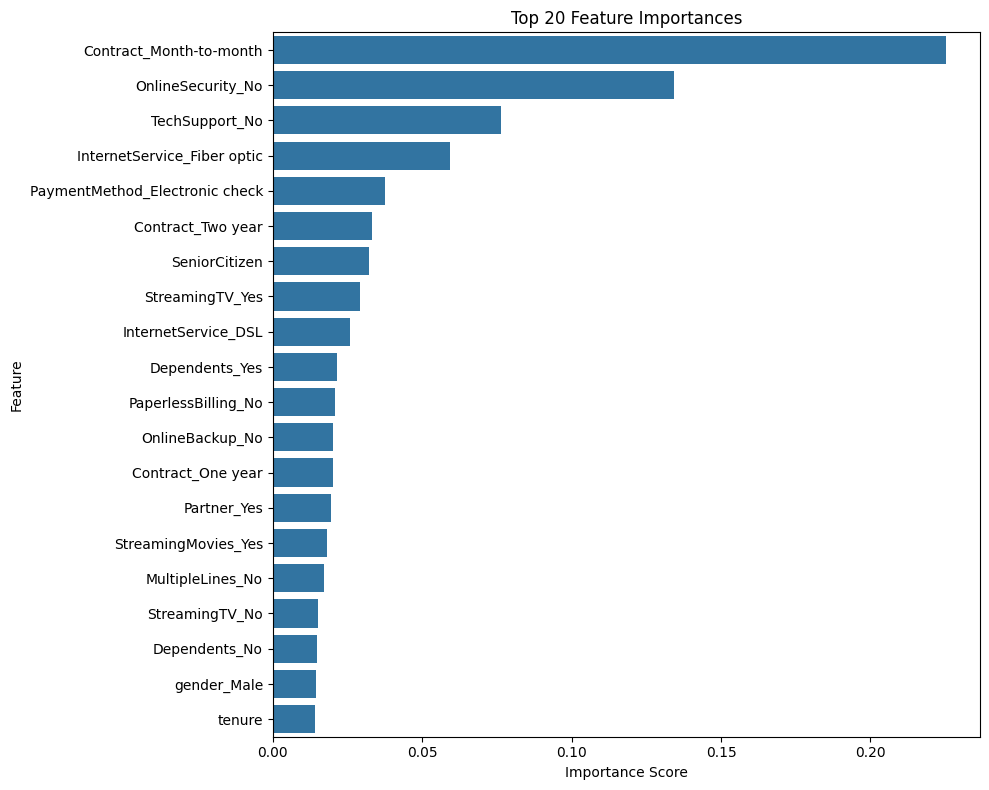

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = df_encoded.drop("Churn", axis=1).columns
importances = best_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[sorted_idx][:20], y=features[sorted_idx][:20])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict
y_pred = best_model.predict(X_test)

# Accuracy and metrics
print("✅ Final Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Final Accuracy on Test Set: 0.8475314617618587
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1033
           1       0.84      0.87      0.85      1033

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



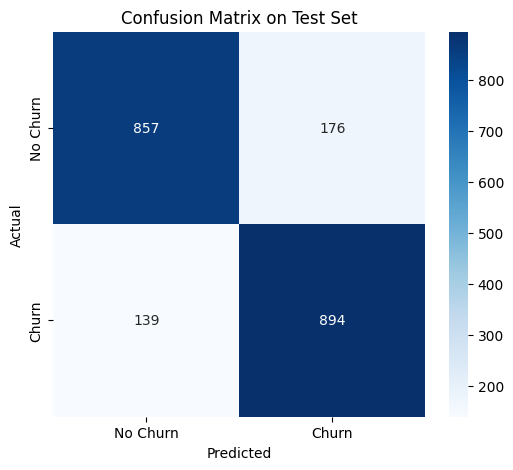

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()
